In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("subhaditya/fer2013plus")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fer2013plus


Found 17179 images belonging to 7 classes.
Found 4365 images belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


537/537 ━━━━━━━━━━━━━━━━━━━━ 112s 185ms/step - accuracy: 0.3885 - loss: 2.0821 - val_accuracy: 0.6726 - val_loss: 0.9257 - learning_rate: 0.0010
Epoch 2/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 34s 62ms/step - accuracy: 0.6245 - loss: 1.0782 - val_accuracy: 0.7040 - val_loss: 0.8319 - learning_rate: 0.0010
Epoch 3/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/step - accuracy: 0.6743 - loss: 0.9290 - val_accuracy: 0.7416 - val_loss: 0.7395 - learning_rate: 0.0010
Epoch 4/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 31s 58ms/step - accuracy: 0.7070 - loss: 0.8415 - val_accuracy: 0.7693 - val_loss: 0.6685 - learning_rate: 0.0010
Epoch 5/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 31s 56ms/step - accuracy: 0.7346 - loss: 0.7806 - val_accuracy: 0.8060 - val_loss: 0.5688 - learning_rate: 0.0010
Epoch 6/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 31s 57ms/step - accuracy: 0.7537 - loss: 0.7271 - val_accuracy: 0.8186 - val_loss: 0.5443 - learning_rate: 0.0010
Epoch 7/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 31s 56ms/step - accuracy: 0.7675 - loss

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

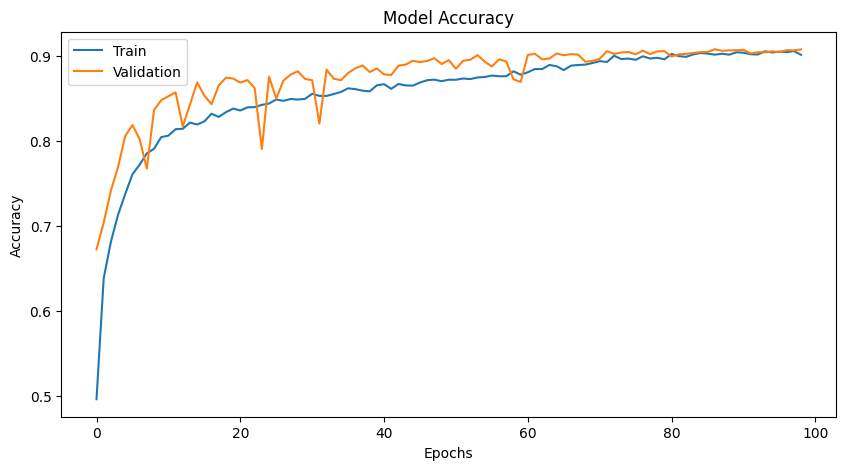

137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step


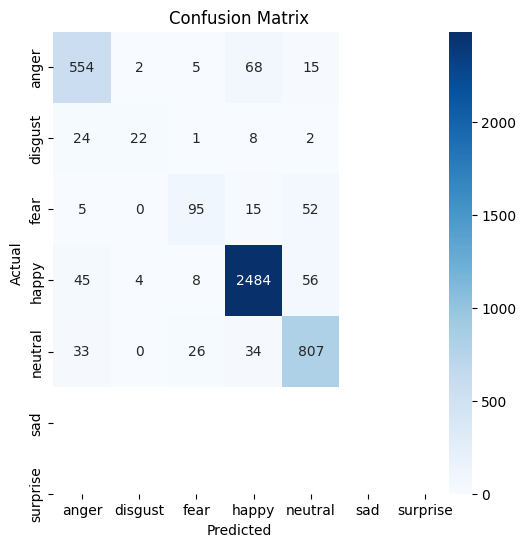

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix

# Define paths to AffectNet dataset
DATASET_PATH = "/kaggle/input/fer2013plus/fer2013plus/fer2013"  # Update if needed
TRAIN_DIR = os.path.join(DATASET_PATH, "train")
TEST_DIR = os.path.join(DATASET_PATH, "test")

# Emotion labels mapping
emotion_label_to_text = {
    "anger": 0, "disgust": 1, "fear": 2, "happy": 3, 
    
    "neutral": 4, "sadness": 5, "surprise": 6
}

# Interested emotions (excluding disgust)
INTERESTED_LABELS = ["anger", "disgust","fear", "happy", "neutral", "sad", "surprise"]

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load training and testing data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(48,48),
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical",
    classes=INTERESTED_LABELS
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(48,48),
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical",
    classes=INTERESTED_LABELS,
    shuffle=False
)

# Define CNN model
def build_net(optimizer):
    model = Sequential()

    model.add(Conv2D(64, (5,5), activation='elu', padding='same', kernel_initializer='he_normal', input_shape=(48,48, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128, activation='elu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))

    model.add(Dense(len(INTERESTED_LABELS), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, min_lr=1e-6)
model_checkpoint = ModelCheckpoint("best_affectnet_model.keras", save_best_only=True, monitor="val_accuracy", mode="max")
callbacks = [early_stopping, lr_scheduler, model_checkpoint]

# Model Training
batch_size = 32
epochs = 100
optimizer = optimizers.Adam(learning_rate=0.001)
model = build_net(optimizer)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
    callbacks=callbacks
)

# Save the final model
model.save("affectnet_emotion_model5.keras")

# Plot Accuracy
plt.figure(figsize=(10,5))
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='Train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=INTERESTED_LABELS, 
            yticklabels=INTERESTED_LABELS)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Found 28221 images belonging to 7 classes.
Found 7048 images belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


882/882 ━━━━━━━━━━━━━━━━━━━━ 64s 64ms/step - accuracy: 0.2617 - loss: 2.2603 - val_accuracy: 0.4150 - val_loss: 1.4891 - learning_rate: 0.0010
Epoch 2/150
882/882 ━━━━━━━━━━━━━━━━━━━━ 51s 57ms/step - accuracy: 0.4207 - loss: 1.5049 - val_accuracy: 0.5061 - val_loss: 1.3694 - learning_rate: 0.0010
Epoch 3/150
882/882 ━━━━━━━━━━━━━━━━━━━━ 51s 57ms/step - accuracy: 0.5412 - loss: 1.2716 - val_accuracy: 0.6179 - val_loss: 1.1232 - learning_rate: 0.0010
Epoch 4/150
882/882 ━━━━━━━━━━━━━━━━━━━━ 57s 64ms/step - accuracy: 0.6000 - loss: 1.1213 - val_accuracy: 0.6862 - val_loss: 0.8829 - learning_rate: 0.0010
Epoch 5/150
882/882 ━━━━━━━━━━━━━━━━━━━━ 54s 61ms/step - accuracy: 0.6363 - loss: 1.0190 - val_accuracy: 0.7115 - val_loss: 0.8209 - learning_rate: 0.0010
Epoch 6/150
882/882 ━━━━━━━━━━━━━━━━━━━━ 51s 58ms/step - accuracy: 0.6610 - loss: 0.9526 - val_accuracy: 0.7263 - val_loss: 0.7987 - learning_rate: 0.0010
Epoch 7/150
882/882 ━━━━━━━━━━━━━━━━━━━━ 52s 58ms/step - accuracy: 0.6717 - loss: 

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

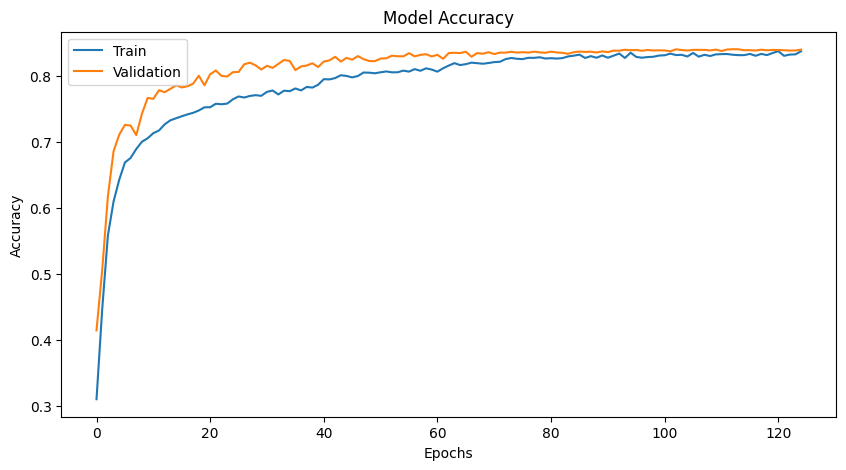

221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step


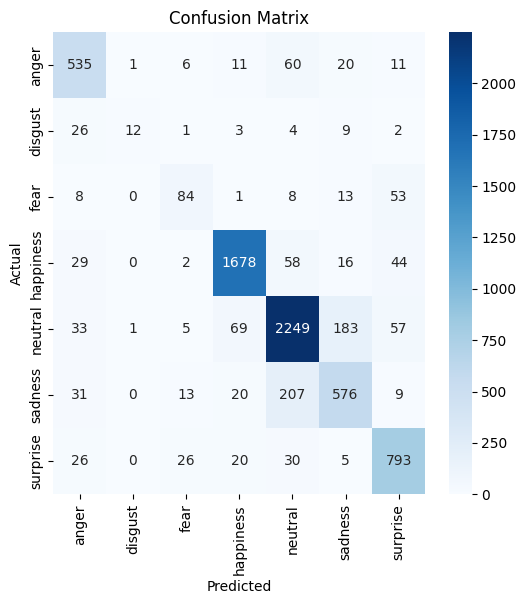

In [8]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix

# Define paths to AffectNet dataset
DATASET_PATH = "/kaggle/input/fer2013plus/fer2013plus/fer2013"  # Update if needed
TRAIN_DIR = os.path.join(DATASET_PATH, "train")
TEST_DIR = os.path.join(DATASET_PATH, "test")

# Emotion labels mapping
emotion_label_to_text = {
    "anger": 0, "disgust": 1, "fear": 2, "happy": 3, 
    "neutral": 4, "sadness": 5, "surprise": 6
}

# Interested emotions (excluding disgust)
INTERESTED_LABELS = ["anger", "disgust","fear", "happiness", "neutral", "sadness", "surprise"]

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load training and testing data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(48,48),
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical",
    classes=INTERESTED_LABELS
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(48,48),
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical",
    classes=INTERESTED_LABELS,
    shuffle=False
)

# Define CNN model
def build_net(optimizer):
    model = Sequential()

    model.add(Conv2D(64, (5,5), activation='elu', padding='same', kernel_initializer='he_normal', input_shape=(48,48, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128, activation='elu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))

    model.add(Dense(len(INTERESTED_LABELS), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, min_lr=1e-6)
model_checkpoint = ModelCheckpoint("best_affectnet_model.keras", save_best_only=True, monitor="val_accuracy", mode="max")
callbacks = [early_stopping, lr_scheduler, model_checkpoint]

# Model Training
batch_size = 32
epochs = 150
optimizer = optimizers.Adam(learning_rate=0.001)
model = build_net(optimizer)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
    callbacks=callbacks
)

# Save the final model
model.save("ferplus_emotion_model5.keras")

# Plot Accuracy
plt.figure(figsize=(10,5))
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='Train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=INTERESTED_LABELS, 
            yticklabels=INTERESTED_LABELS)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Found 28386 images belonging to 8 classes.
Found 7099 images belonging to 8 classes.
Epoch 1/150
888/888 ━━━━━━━━━━━━━━━━━━━━ 69s 67ms/step - accuracy: 0.2549 - loss: 2.2130 - val_accuracy: 0.4333 - val_loss: 1.4869 - learning_rate: 0.0010
Epoch 2/150
888/888 ━━━━━━━━━━━━━━━━━━━━ 55s 62ms/step - accuracy: 0.4068 - loss: 1.5458 - val_accuracy: 0.4847 - val_loss: 1.4479 - learning_rate: 0.0010
Epoch 3/150
888/888 ━━━━━━━━━━━━━━━━━━━━ 106s 118ms/step - accuracy: 0.5054 - loss: 1.3714 - val_accuracy: 0.6423 - val_loss: 1.0281 - learning_rate: 0.0010
Epoch 4/150
888/888 ━━━━━━━━━━━━━━━━━━━━ 106s 119ms/step - accuracy: 0.5804 - loss: 1.1950 - val_accuracy: 0.6680 - val_loss: 0.9591 - learning_rate: 0.0010
Epoch 5/150
888/888 ━━━━━━━━━━━━━━━━━━━━ 49s 54ms/step - accuracy: 0.6157 - loss: 1.1038 - val_accuracy: 0.7005 - val_loss: 0.8477 - learning_rate: 0.0010
Epoch 6/150
888/888 ━━━━━━━━━━━━━━━━━━━━ 52s 58ms/step - accuracy: 0.6477 - loss: 1.0200 - val_accuracy: 0.7129 - val_loss: 0.8105 - lea

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

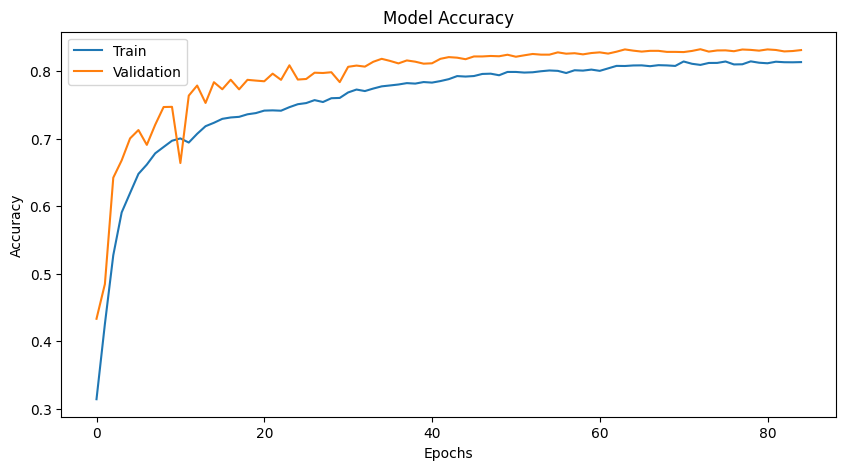

222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step


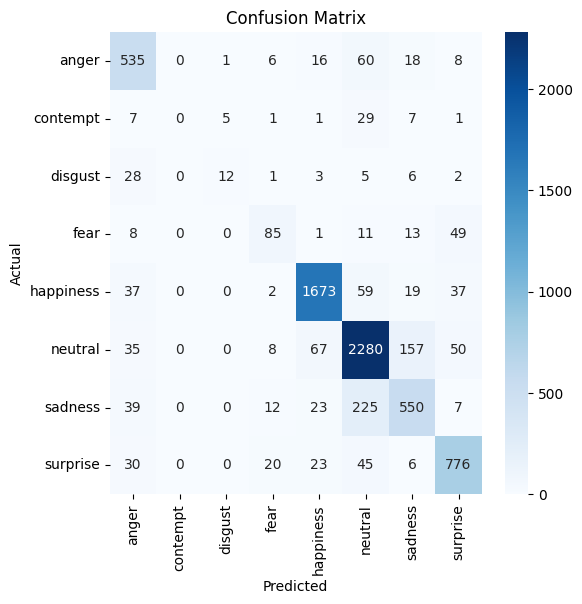

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix

# Define paths to AffectNet dataset
DATASET_PATH = "/kaggle/input/fer2013plus/fer2013plus/fer2013"  # Update if needed
TRAIN_DIR = os.path.join(DATASET_PATH, "train")
TEST_DIR = os.path.join(DATASET_PATH, "test")

# Emotion labels mapping
emotion_label_to_text = {
    "anger": 0,"contempt":1, "disgust": 2, "fear": 3, "happy": 4, 
    "neutral": 5, "sadness": 6, "surprise": 7
}

# Interested emotions (excluding disgust)
# Interested emotions (including contempt)
INTERESTED_LABELS = ["anger", "contempt", "disgust", "fear", "happiness", "neutral", "sadness", "surprise"]


# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load training and testing data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(48,48),
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical",
    classes=INTERESTED_LABELS
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(48,48),
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical",
    classes=INTERESTED_LABELS,
    shuffle=False
)

# Define CNN model
def build_net(optimizer):
    model = Sequential()

    model.add(Conv2D(64, (5,5), activation='elu', padding='same', kernel_initializer='he_normal', input_shape=(48,48, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128, activation='elu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))

    model.add(Dense(len(INTERESTED_LABELS), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, min_lr=1e-6)
model_checkpoint = ModelCheckpoint("best_affectnet_model.keras", save_best_only=True, monitor="val_accuracy", mode="max")
callbacks = [early_stopping, lr_scheduler, model_checkpoint]

# Model Training
batch_size = 32
epochs = 150
optimizer = optimizers.Adam(learning_rate=0.001)
model = build_net(optimizer)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
    callbacks=callbacks
)

# Save the final model
model.save("ferplus_emotion_model2.keras")

# Plot Accuracy
plt.figure(figsize=(10,5))
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='Train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=INTERESTED_LABELS, 
            yticklabels=INTERESTED_LABELS)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


888/888 ━━━━━━━━━━━━━━━━━━━━ 84s 94ms/step


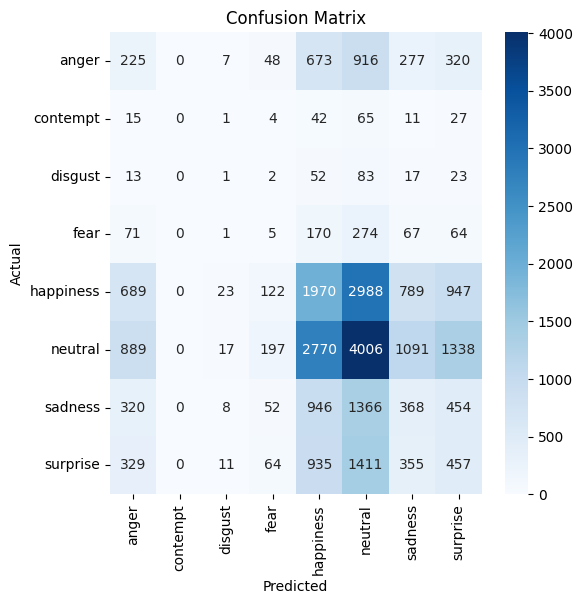

In [7]:
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the trained model
model = load_model("ferplus_emotion_model2.keras")
# Get the true labels
y_true = train_generator.classes

# Predict the class probabilities
y_pred_prob = model.predict(train_generator)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=INTERESTED_LABELS, 
            yticklabels=INTERESTED_LABELS)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [5]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# Load the trained model
model = load_model("ferplus_emotion_model2.keras")

# Predict on test data
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_true = test_generator.classes  # True labels

# Compute metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Print results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=INTERESTED_LABELS))


222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step
Test Accuracy: 0.8327
Test Precision: 0.8245
Test Recall: 0.8327
Test F1-score: 0.8269

Classification Report:
              precision    recall  f1-score   support

       anger       0.74      0.83      0.79       644
    contempt       0.00      0.00      0.00        51
     disgust       0.67      0.21      0.32        57
        fear       0.63      0.51      0.56       167
   happiness       0.93      0.92      0.92      1827
     neutral       0.84      0.88      0.86      2597
     sadness       0.71      0.64      0.67       856
    surprise       0.83      0.86      0.85       900

    accuracy                           0.83      7099
   macro avg       0.67      0.61      0.62      7099
weighted avg       0.82      0.83      0.83      7099



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

In [17]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model, Model

# Emotion label map
INTERESTED_LABELS = ["anger", "contempt", "disgust", "fear", "happiness", "neutral", "sadness", "surprise"]

# Load the pre-trained emotion classification model
model = load_model("ferplus_emotion_model2.keras")

# Function to preprocess image into array
def get_img_array(img_path, size=(48, 48)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, size)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=[0, -1])  # Shape: (1, 48, 48, 1)
    return img

# Function to generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy(), tf.argmax(predictions[0])

# Function to overlay and save Grad-CAM result
def display_gradcam(img_path, model, output_dir, last_conv_layer_name="conv2d_11"):
    img_array = get_img_array(img_path)
    heatmap, pred_label = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    emotion = INTERESTED_LABELS[pred_label]

    # Read original image for overlay
    img = cv2.imread(img_path)
    img = cv2.resize(img, (48, 48))

    # Apply heatmap to image
    heatmap_resized = cv2.resize(heatmap, (48, 48))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)

    # Save output
    filename = os.path.basename(img_path)
    out_path = os.path.join(output_dir, f"{emotion}_{filename}")
    cv2.imwrite(out_path, superimposed_img)
    print(f"Saved Grad-CAM for {filename} as {out_path}")

# Loop over a folder of dataset images and apply Grad-CAM
def run_gradcam_on_dataset(dataset_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for filename in os.listdir(dataset_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(dataset_folder, filename)
            display_gradcam(
                img_path=img_path,
                model=model,
                output_dir=output_folder,
                last_conv_layer_name="conv2d_11"
            )

# 🔁 Example usage
# Replace "your_dataset_folder" with your actual image folder in Kaggle (e.g., "../input/your-data")
run_gradcam_on_dataset("/kaggle/input/fer2013plus/fer2013plus/fer2013", "gradcam_outputs")


In [5]:
import os
INTERESTED_LABELS = ["anger", "contempt", "disgust", "fear", "happiness", "neutral", "sadness", "surprise"]

for label in INTERESTED_LABELS:
    label_path = os.path.join(TRAIN_DIR, label)
    print(f"{label}: {len(os.listdir(label_path))} images")


NameError: name 'TRAIN_DIR' is not defined